**IMPORTING REQUIRED LIBRARIES**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import cv2
import pathlib
import glob
import shutil
import os
import random


**IMPORTING THE DATA**

In [ ]:
######################################### caution : terminal commands #######################################################

#-------------------------------------empty the datasets forlder before downloading the dataset -------------------------------------

%cd
%cd .keras/datasets/
!rm -r *

/root
[Errno 2] No such file or directory: '.keras/datasets/'
/root
rm: cannot remove '*': No such file or directory


In [ ]:
########################################### download data from given url ###############################################3

dataset_url = "https://storage.googleapis.com/wandb_datasets/nature_12K.zip"
data_dir = tf.keras.utils.get_file('nature_12K', origin=dataset_url, extract=True)


3816693760/3816687935 [==============================] - 77s 0us/step


**SPLITTING THE DATA**

In [ ]:
#---------------------------------------------caution : terminal commands ----------------------------------------------

%cd
%cd .keras/datasets/inaturalist_12K
%mv val test
!mkdir valid

/root
/root/.keras/datasets/inaturalist_12K


In [ ]:
#################################### split train data into validation set and training set ###################################

data_folder = '/root/.keras/datasets/inaturalist_12K'
os.chdir(data_folder)

folder_names = ['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia' ]
for i in range(0,10):
  source = data_folder + "/train/" +folder_names[i]  
  orig_files = os.listdir(source)
  chosen_indexes = random.sample(range(0, len(orig_files)-1), 100)

  destination = data_folder + "/valid/"
  os.chdir(destination)
  os.system('mkdir'+' '+str(folder_names[i]))
  destination = destination + folder_names[i]
  for j in range(0,100):
    shutil.move(   source +"/" + str(   orig_files[   chosen_indexes[j]  ]   )  , destination)


In [ ]:
####################################### Correcting the directory location ####################################################

#data_dir = '/root/.keras/datasets/nature_12K'

data_dir = data_dir.split('/')
data_dir.remove('nature_12K')
data_dir.append('inaturalist_12K')
data_dir = '/'.join(data_dir)


In [ ]:
#-------------------------------------Taking the train data--------------------------------------------------------
train_data_dir_path = data_dir + '/train'
train_data_dir = pathlib.Path(train_data_dir_path)

#--------------------------------------Taking the validation data-----------------------------------------------
valid_data_dir_path = data_dir + '/valid'
valid_data_dir = pathlib.Path(valid_data_dir_path)

#----------------------------------------Taking the test data-----------------------------------------------
test_data_dir_path = data_dir + '/test'
test_data_dir = pathlib.Path(test_data_dir_path)

In [ ]:
#------------------------------------------Parameters for the images-------------------------------------------------
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
####################################### converting the image data into dataset ############################################

#-------------------------------------training dataset -----------------------------------------------------
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

#----------------------------------------------validation dataset -----------------------------------------------
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  valid_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

#----------------------------------------------test dataset -----------------------------------------------
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

Found 9000 files belonging to 10 classes.
Found 999 files belonging to 10 classes.
Found 2000 files belonging to 10 classes.


**CONVOLUTIONAL NEURAL NETWORK**

In [ ]:
class CNN():

############################################# constructor for class CNN ##########################################
  def __init__(self, filter_count, filter_size, active_func, dense_neurons_count, maxpool_size, output_neurons_count, data_augmentation, drop_out, batch_normalisation, optimizer='adam'):
    self.filter_count = filter_count
    self.filter_size = filter_size
    self.active_func = active_func
    self.dense_neurons_count = dense_neurons_count
    self.maxpool_size = maxpool_size
    self.num_classes = output_neurons_count
    self.optimizer = optimizer
    self.data_augmentation = data_augmentation
    self.drop_out = drop_out
    self.batch_normalisation = batch_normalisation

    #harcoded values
    self.img_height = 180
    self.img_width = 180

    #creating the CNN model
    self.model = self.create_model(5)


############################################### function to create model ####################################################
  def create_model(self, num_layers):    
    
    # #-------------------------------------------creating the CNN model -----------------------------------------------------

    augmentations = [     layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
                          layers.experimental.preprocessing.RandomRotation(0.1),
                          layers.experimental.preprocessing.RandomZoom(0.1)
                    ]

    data_augment = keras.Sequential(augmentations)

    layerslist = []

    #------------------Data Augmentation---------------------------------------
    if self.data_augmentation == "Yes":
      layerslist.append(data_augment)

    #------------------Including a normalisation layer in the model---------------------------------------
    layerslist.append(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(self.img_height, self.img_width, 3)))

    #------------------Creating (convolution,activation,maxpool) layers in the model---------------------------------------
    for i in range(0,num_layers):
      layerslist.append(layers.Conv2D(self.filter_count[i], self.filter_size[i], padding='same', activation = self.active_func[i]))
      if self.batch_normalisation[i] == 'Yes':
        layerslist.append(layers.BatchNormalization( axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,
                                                     beta_initializer='zeros', gamma_initializer='ones',
                                                     moving_mean_initializer='zeros', moving_variance_initializer='ones'))
      layerslist.append(layers.MaxPooling2D(pool_size = self.maxpool_size[i]))

    layerslist.append(layers.Dropout(self.drop_out))
    layerslist.append(layers.Flatten())
    layerslist.append(layers.Dense(self.dense_neurons_count,  activation = self.active_func[num_layers]))
    # layerslist.append(layers.Dense(self.num_classes))
    layerslist.append(layers.Dense(self.num_classes, activation = "softmax"))

    model = Sequential(layerslist)

    # ---------------------------------------compiling the CNN model ----------------------------------------------------------
    model.compile(
    optimizer = self.optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'] )


  #--------------------------------------------- return final model --------------------------------------------------------
    return model 


  
############################################## function for training the model ##################################################3
  def train(self, train_ds, val_ds, epochs = 10):

    #------------------------------------caching the datasets -----------------------------------------------
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    #------------------------------------ training the model -----------------------------------------------
    # history = self.model.fit( train_ds, validation_data=val_ds, epochs=epochs, callbacks=[WandbCallback()] )
    history = self.model.fit( train_ds, validation_data=val_ds, epochs=epochs)

    return history

############################################ function for summary of model ###########################################
  def model_save(self, file_name):
    return self.model.save(file_name)

############################################ function for summary of model ###########################################
  def model_summary(self):
    return self.model.summary()

############################################ function for testing the model ###########################################
  def test(self, test_ds):  
      predictions = self.model.predict(test_ds)
      return predictions

#=============================================== end of class CNN ======================================================
    

In [ ]:
# sweep parameters
filter_count = [16,32,64,128,256]
filter_size = [3,3,3,3,3]
data_augmentation = "No"
drop_out = 0.2
batch_normalisation = ["Yes","Yes","Yes","Yes","Yes"]
epochs = 10

#fixed parameters
maxpool_size = [2,2,2,2,2]
active_func = ['relu']*6
dense_neurons_count = 120
output_neurons_count = 10


cnn = CNN(filter_count, filter_size, active_func, dense_neurons_count, maxpool_size, output_neurons_count, data_augmentation, drop_out, batch_normalisation)


In [ ]:
#training the model
history = cnn.train(train_ds, val_ds, epochs)

**Q4 (a) Use the best model from your sweep and report the accuracy on the test set.**

In [ ]:
# Function to calculate accuracy
def calculate_accuracy(pred, test_ds):
  predictions = [np.argmax(tf.nn.softmax(predict)) for predict in pred]
  test_labels = np.concatenate([y for x, y in test_ds], axis=0)
  correct = 0
  for (prediction, label) in list(zip(predictions,test_labels)):
    if prediction == label:
      correct += 1
  return (correct/2000)*100

In [ ]:
pred = cnn.test(test_ds)
print(calculate_accuracy(pred, test_ds))

10.35


**Q4 (b) Provide a 10 x 3 grid containing sample images from the test data and predictions made by your best model (more marks for presenting this grid creatively).**

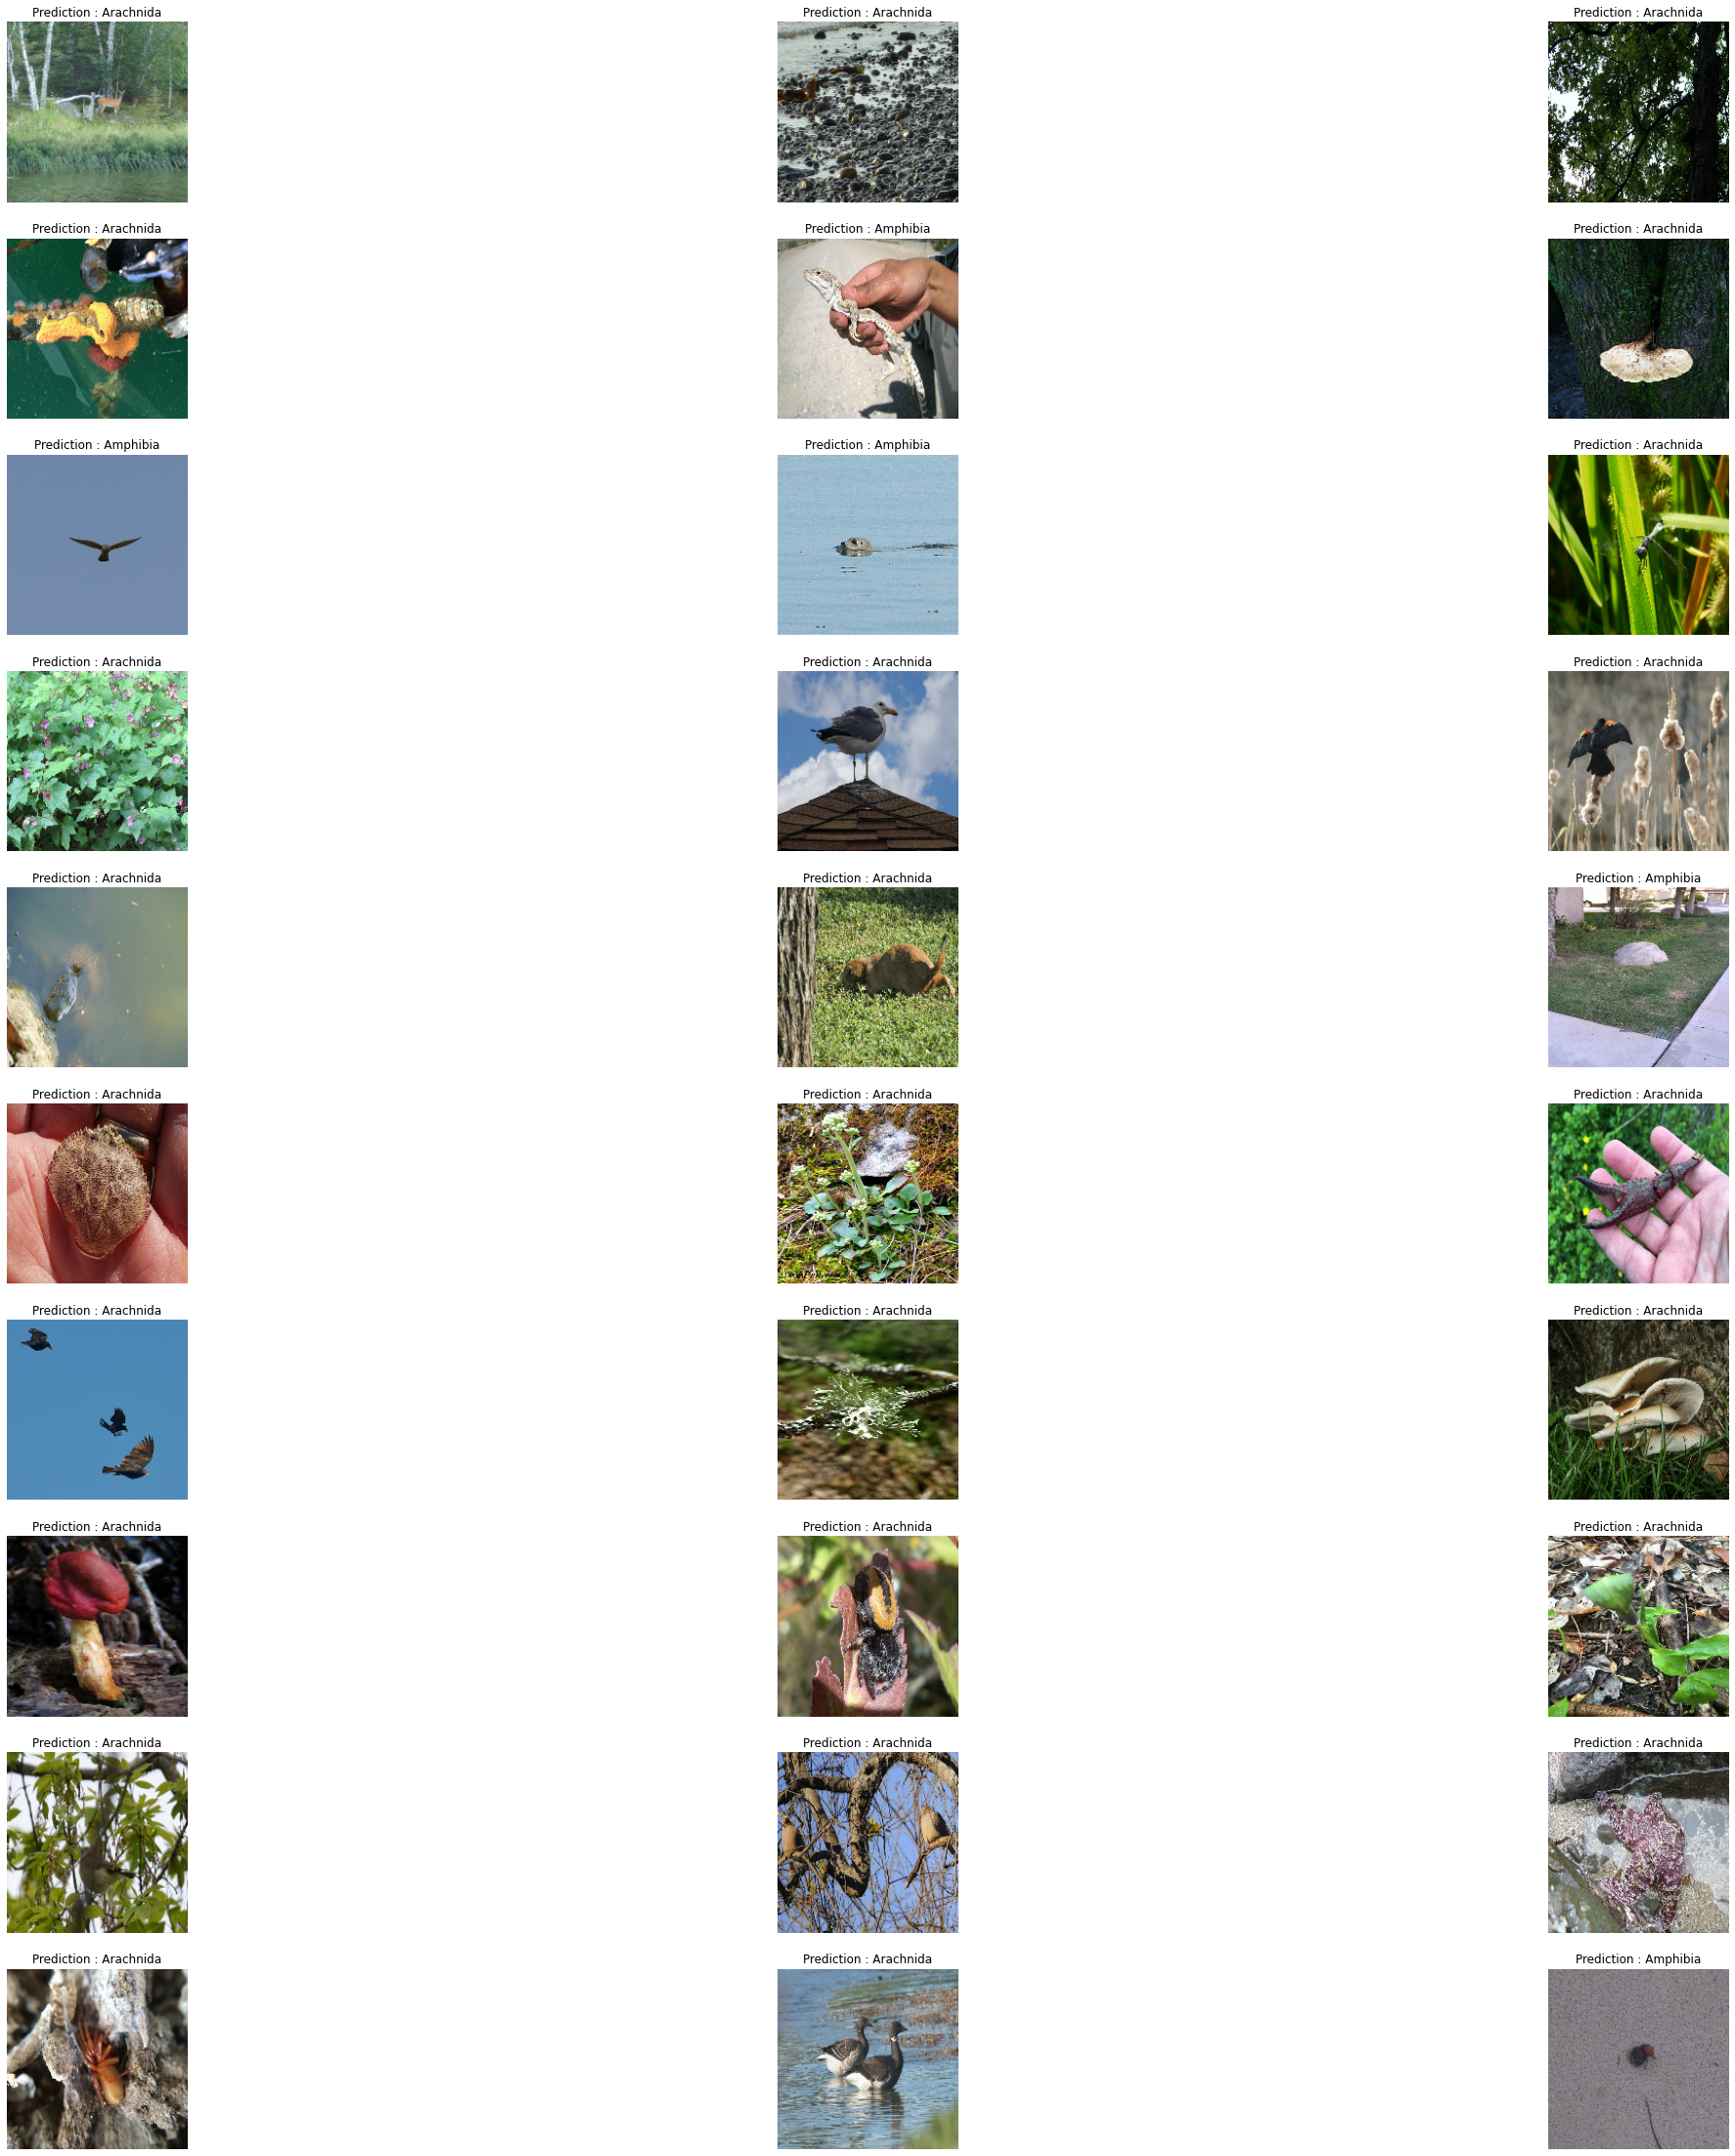

In [ ]:
class_names = train_ds.class_names

plt.figure(figsize=(40, 40))
for images, labels in test_ds.take(1):
  for i in range(30):
    ax = plt.subplot(10, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    img = layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))(tf.expand_dims(images[i].numpy(),0))
    title = "Prediction : " + class_names[np.argmax(tf.nn.softmax(cnn.test(img)))]
    # title = "true label : " + class_names[labels[i]]+"\n Prediction : " + class_names[np.argmax(tf.nn.softmax(cnn.test(img)))]
    plt.title(title)
    plt.axis("off")